### Data Preprocessing

In [335]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import csv
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import time
import os


In [336]:
# Load the dataset into a pandas dataframe
df = pd.read_csv('airline-passengers.csv')

# Convert the 'Month' column to a datetime format
df['Month'] = pd.to_datetime(df['Month'])

# Extract the year and month from the datetime column and create separate columns for them
df['Year'] = df['Month'].dt.year
df['Month'] = df['Month'].dt.month

# Print the modified dataframe
print(df)

     Month  Passengers  Year
0        1         112  1949
1        2         118  1949
2        3         132  1949
3        4         129  1949
4        5         121  1949
..     ...         ...   ...
139      8         606  1960
140      9         508  1960
141     10         461  1960
142     11         390  1960
143     12         432  1960

[144 rows x 3 columns]


In [337]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['Passengers']].values.astype('float32'))

# Split the data into train andf[['Passengers']].values.astype('float32')d test sets
train_size = int(len(scaled_data) * 0.75)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [338]:
def sliding_window(data, window_size):
    X, y = [], []
    for i in range(len(data)-window_size):
        X.append(torch.tensor(data[i:i+window_size, :]))
        y.append(torch.tensor(data[i+window_size, :]))
    return torch.stack(X), torch.stack(y)

window_size = 3
X_train, y_train = sliding_window(train_data, window_size)
X_test, y_test = sliding_window(test_data, window_size)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


torch.Size([105, 3, 1]) torch.Size([105, 1])
torch.Size([33, 3, 1]) torch.Size([33, 1])


### Training and Testing Data


In [339]:
import torch.nn as nn
import math
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_neurons, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.Relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_neurons)
        self.fc2 = nn.Linear(hidden_neurons, math.floor(hidden_neurons/4))
        self.fc3 = nn.Linear(math.floor(hidden_neurons/4), output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc1(out[:, -1, :])
        out = self.Relu(out)
        out = self.fc2(out)
        out = self.Relu(out)
        out = self.fc3(out)
        return out


In [340]:
input_dim = 1
hidden_dim = 400
hidden_neurons = 320
num_layers = 2
output_dim = 1
lstm = LSTM(input_dim, hidden_dim, hidden_neurons, num_layers, output_dim)


train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8)

In [341]:
lstm

LSTM(
  (lstm): LSTM(1, 400, num_layers=2, batch_first=True)
  (Relu): ReLU(inplace=True)
  (fc1): Linear(in_features=400, out_features=320, bias=True)
  (fc2): Linear(in_features=320, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=1, bias=True)
)

In [342]:
# Define your loss function
criterion = nn.MSELoss()

# Define your optimizer
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

# Set the number of epochs to train for
num_epochs = 1000

# Train the model
for epoch in range(num_epochs):
    # Set the model to train mode
    lstm.train()
    
    # Initialize the running loss
    running_loss = 0.0
    
    # Loop over the training data in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = lstm(data)
        
        # Compute the loss
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Update the running loss
        running_loss += loss.item()
    
    # Compute the average training loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    
    # Print the average training loss for this epoch
    print('Epoch [{}/{}], Average Training Loss: {:.4f}'.format(epoch+1, num_epochs, avg_train_loss))




Epoch [1/1000], Average Training Loss: 0.4848
Epoch [2/1000], Average Training Loss: 0.2297
Epoch [3/1000], Average Training Loss: 0.1304
Epoch [4/1000], Average Training Loss: 0.1164
Epoch [5/1000], Average Training Loss: 0.1239
Epoch [6/1000], Average Training Loss: 0.0998
Epoch [7/1000], Average Training Loss: 0.1282
Epoch [8/1000], Average Training Loss: 0.1191
Epoch [9/1000], Average Training Loss: 0.0969
Epoch [10/1000], Average Training Loss: 0.1016
Epoch [11/1000], Average Training Loss: 0.0777
Epoch [12/1000], Average Training Loss: 0.0984
Epoch [13/1000], Average Training Loss: 0.0823
Epoch [14/1000], Average Training Loss: 0.0670
Epoch [15/1000], Average Training Loss: 0.0619
Epoch [16/1000], Average Training Loss: 0.0901
Epoch [17/1000], Average Training Loss: 0.0526
Epoch [18/1000], Average Training Loss: 0.0415
Epoch [19/1000], Average Training Loss: 0.0403
Epoch [20/1000], Average Training Loss: 0.0447
Epoch [21/1000], Average Training Loss: 0.0420
Epoch [22/1000], Avera

Epoch [175/1000], Average Training Loss: 0.0321
Epoch [176/1000], Average Training Loss: 0.0339
Epoch [177/1000], Average Training Loss: 0.0314
Epoch [178/1000], Average Training Loss: 0.0419
Epoch [179/1000], Average Training Loss: 0.0514
Epoch [180/1000], Average Training Loss: 0.0543
Epoch [181/1000], Average Training Loss: 0.0457
Epoch [182/1000], Average Training Loss: 0.0372
Epoch [183/1000], Average Training Loss: 0.0314
Epoch [184/1000], Average Training Loss: 0.0311
Epoch [185/1000], Average Training Loss: 0.0303
Epoch [186/1000], Average Training Loss: 0.0290
Epoch [187/1000], Average Training Loss: 0.0371
Epoch [188/1000], Average Training Loss: 0.0356
Epoch [189/1000], Average Training Loss: 0.0267
Epoch [190/1000], Average Training Loss: 0.0322
Epoch [191/1000], Average Training Loss: 0.0310
Epoch [192/1000], Average Training Loss: 0.0339
Epoch [193/1000], Average Training Loss: 0.0352
Epoch [194/1000], Average Training Loss: 0.0377
Epoch [195/1000], Average Training Loss:

Epoch [347/1000], Average Training Loss: 0.0210
Epoch [348/1000], Average Training Loss: 0.0258
Epoch [349/1000], Average Training Loss: 0.0180
Epoch [350/1000], Average Training Loss: 0.0215
Epoch [351/1000], Average Training Loss: 0.0203
Epoch [352/1000], Average Training Loss: 0.0159
Epoch [353/1000], Average Training Loss: 0.0222
Epoch [354/1000], Average Training Loss: 0.0453
Epoch [355/1000], Average Training Loss: 0.0264
Epoch [356/1000], Average Training Loss: 0.0356
Epoch [357/1000], Average Training Loss: 0.0401
Epoch [358/1000], Average Training Loss: 0.0433
Epoch [359/1000], Average Training Loss: 0.0416
Epoch [360/1000], Average Training Loss: 0.0559
Epoch [361/1000], Average Training Loss: 0.0446
Epoch [362/1000], Average Training Loss: 0.0364
Epoch [363/1000], Average Training Loss: 0.0271
Epoch [364/1000], Average Training Loss: 0.0316
Epoch [365/1000], Average Training Loss: 0.0226
Epoch [366/1000], Average Training Loss: 0.0191
Epoch [367/1000], Average Training Loss:

Epoch [519/1000], Average Training Loss: 0.0169
Epoch [520/1000], Average Training Loss: 0.0327
Epoch [521/1000], Average Training Loss: 0.0320
Epoch [522/1000], Average Training Loss: 0.0298
Epoch [523/1000], Average Training Loss: 0.0196
Epoch [524/1000], Average Training Loss: 0.0189
Epoch [525/1000], Average Training Loss: 0.0176
Epoch [526/1000], Average Training Loss: 0.0172
Epoch [527/1000], Average Training Loss: 0.0146
Epoch [528/1000], Average Training Loss: 0.0139
Epoch [529/1000], Average Training Loss: 0.0142
Epoch [530/1000], Average Training Loss: 0.0121
Epoch [531/1000], Average Training Loss: 0.0120
Epoch [532/1000], Average Training Loss: 0.0115
Epoch [533/1000], Average Training Loss: 0.0118
Epoch [534/1000], Average Training Loss: 0.0127
Epoch [535/1000], Average Training Loss: 0.0161
Epoch [536/1000], Average Training Loss: 0.0103
Epoch [537/1000], Average Training Loss: 0.0107
Epoch [538/1000], Average Training Loss: 0.0102
Epoch [539/1000], Average Training Loss:

Epoch [691/1000], Average Training Loss: 0.0113
Epoch [692/1000], Average Training Loss: 0.0097
Epoch [693/1000], Average Training Loss: 0.0092
Epoch [694/1000], Average Training Loss: 0.0090
Epoch [695/1000], Average Training Loss: 0.0082
Epoch [696/1000], Average Training Loss: 0.0095
Epoch [697/1000], Average Training Loss: 0.0089
Epoch [698/1000], Average Training Loss: 0.0086
Epoch [699/1000], Average Training Loss: 0.0075
Epoch [700/1000], Average Training Loss: 0.0104
Epoch [701/1000], Average Training Loss: 0.0078
Epoch [702/1000], Average Training Loss: 0.0086
Epoch [703/1000], Average Training Loss: 0.0087
Epoch [704/1000], Average Training Loss: 0.0091
Epoch [705/1000], Average Training Loss: 0.0100
Epoch [706/1000], Average Training Loss: 0.0094
Epoch [707/1000], Average Training Loss: 0.0073
Epoch [708/1000], Average Training Loss: 0.0108
Epoch [709/1000], Average Training Loss: 0.0147
Epoch [710/1000], Average Training Loss: 0.0142
Epoch [711/1000], Average Training Loss:

Epoch [863/1000], Average Training Loss: 0.0122
Epoch [864/1000], Average Training Loss: 0.0103
Epoch [865/1000], Average Training Loss: 0.0098
Epoch [866/1000], Average Training Loss: 0.0162
Epoch [867/1000], Average Training Loss: 0.0210
Epoch [868/1000], Average Training Loss: 0.0240
Epoch [869/1000], Average Training Loss: 0.0169
Epoch [870/1000], Average Training Loss: 0.0148
Epoch [871/1000], Average Training Loss: 0.0199
Epoch [872/1000], Average Training Loss: 0.0108
Epoch [873/1000], Average Training Loss: 0.0119
Epoch [874/1000], Average Training Loss: 0.0083
Epoch [875/1000], Average Training Loss: 0.0082
Epoch [876/1000], Average Training Loss: 0.0093
Epoch [877/1000], Average Training Loss: 0.0095
Epoch [878/1000], Average Training Loss: 0.0091
Epoch [879/1000], Average Training Loss: 0.0079
Epoch [880/1000], Average Training Loss: 0.0084
Epoch [881/1000], Average Training Loss: 0.0070
Epoch [882/1000], Average Training Loss: 0.0085
Epoch [883/1000], Average Training Loss:

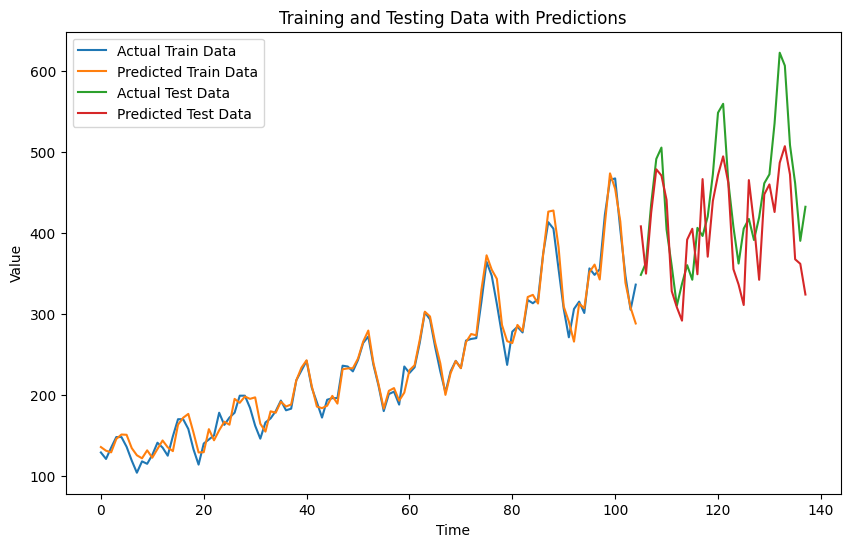

In [343]:
# Set model to evaluation mode
lstm.eval()

# Make predictions
train_predict = lstm(X_train)
test_predict = lstm(X_test)

# Inverse transform the scaled data
train_predict = scaler.inverse_transform(train_predict.detach().numpy())
y_train = scaler.inverse_transform(y_train.numpy())
test_predict = scaler.inverse_transform(test_predict.detach().numpy())
y_test = scaler.inverse_transform(y_test.numpy())

# Plot the training, testing, and predicted data
plt.figure(figsize=(10, 6))
plt.plot(y_train, label="Actual Train Data")
plt.plot(train_predict, label="Predicted Train Data")
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label="Actual Test Data")
plt.plot(range(len(y_train), len(y_train) + len(y_test)), test_predict, label="Predicted Test Data")
plt.title("Training and Testing Data with Predictions")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()


In [344]:
# this is the call that does the work
quantized_lstm = torch.quantization.quantize_dynamic(
    lstm, {nn.LSTM, nn.Linear}, dtype=torch.qint8
)


In [345]:
# show the changes that were made
print('Here is the floating point version of this module:')
print(lstm)
print('')
print('and now the quantized version:')
print(quantized_lstm)

Here is the floating point version of this module:
LSTM(
  (lstm): LSTM(1, 400, num_layers=2, batch_first=True)
  (Relu): ReLU(inplace=True)
  (fc1): Linear(in_features=400, out_features=320, bias=True)
  (fc2): Linear(in_features=320, out_features=80, bias=True)
  (fc3): Linear(in_features=80, out_features=1, bias=True)
)

and now the quantized version:
LSTM(
  (lstm): DynamicQuantizedLSTM(1, 400, num_layers=2, batch_first=True)
  (Relu): ReLU(inplace=True)
  (fc1): DynamicQuantizedLinear(in_features=400, out_features=320, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc2): DynamicQuantizedLinear(in_features=320, out_features=80, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (fc3): DynamicQuantizedLinear(in_features=80, out_features=1, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)


In [346]:

def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size

# compare the sizes
f=print_size_of_model(lstm,"fp32")
q=print_size_of_model(quantized_lstm,"int8")
print("{0:.2f} times smaller".format(f/q))

model:  fp32  	 Size (KB): 8331.787
model:  int8  	 Size (KB): 2108.583
3.95 times smaller


In [347]:
def evaluate(model, test_loader):
    # Set model to eval mode
    model.eval()

    # Initialize lists to store predicted and actual values
    y_pred = []
    y_actual = []

    # Iterate over test data batches
    with torch.no_grad():
        start_time = time.time()
        for inputs, targets in test_loader:
            # Make predictions using the model
            outputs = model(inputs)

            # Save predicted and actual values
            y_pred.extend(outputs.flatten().tolist())
            y_actual.extend(targets.flatten().tolist())
        end_time = time.time()

    # Calculate mean squared error (MSE) and root mean squared error (RMSE)
    mse = mean_squared_error(y_actual, y_pred)
    rmse = torch.sqrt(F.mse_loss(torch.tensor(y_pred), torch.tensor(y_actual)))

    # Calculate CPU latency
    cpu_latency = (end_time - start_time) / len(test_loader)

    return mse, rmse, cpu_latency


In [348]:

def generate_stats_csv(model, test_loader, csv_filename):
    # Generate quantized model
    quantized_model = torch.quantization.quantize_dynamic(
        model, {nn.LSTM, nn.Linear}, dtype=torch.qint8
    )

    # Evaluate floating point model
    fp_mse,_, fp_cpu_latency = evaluate(model, test_loader)
    #fp_rmse = torch.sqrt(fp_mse)

    # Evaluate quantized model
    q_mse,_, q_cpu_latency = evaluate(quantized_model, test_loader)
   # q_rmse = torch.sqrt(q_mse)

    # Calculate model file sizes
    fp_size = print_size_of_model(model, label="Floating Point")
    q_size = print_size_of_model(quantized_model, label="Quantized")

    # Write results to CSV file
    # Check if CSV file already exists, create it if not
    file_exists = os.path.isfile(csv_filename)
    with open(csv_filename, "a", newline="") as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(["Model", "MSE", "CPU Latency (ms)", "File Size (KB)"])
        writer.writerow(["Floating Point", f"{fp_mse:.2f}", f"{fp_cpu_latency*1000:.2f}", f"{fp_size/1024:.2f}"])
        writer.writerow(["Quantized", f"{q_mse:.2f}", f"{q_cpu_latency*1000:.2f}", f"{q_size/1024:.2f}"])


In [349]:
def generate_stats_csv2(model, test_loader, csv_filename, model_name):
    # Generate quantized model
    quantized_model = torch.quantization.quantize_dynamic(
        model, {nn.LSTM, nn.Linear}, dtype=torch.qint8
    )

    # Evaluate floating point model
    fp_mse, _, fp_cpu_latency = evaluate(model, test_loader)

    # Evaluate quantized model
    q_mse, _, q_cpu_latency = evaluate(quantized_model, test_loader)

    # Calculate model file sizes
    fp_size = print_size_of_model(model, label="Floating Point")
    q_size = print_size_of_model(quantized_model, label="Quantized")

    # Use the model_name parameter to name the models
    fp_model_name = f"{model_name}_FP"
    q_model_name = f"{model_name}_Quantized"

    # Write results to CSV file
    file_exists = os.path.isfile(csv_filename)
    with open(csv_filename, "a", newline="") as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(["Model", "MSE", "CPU Latency (ms)", "File Size (MB)"])
        writer.writerow([fp_model_name, f"{fp_mse:.3f}", f"{fp_cpu_latency*1000:.2f}", f"{fp_size/1024:.2f}"])
        writer.writerow([q_model_name, f"{q_mse:.3f}", f"{q_cpu_latency*1000:.2f}", f"{q_size/1024:.2f}"])


In [350]:
lstm_stats = "lstm_statistics.csv"
generate_stats_csv2(lstm,test_loader,lstm_stats,"LSTM_400_320_80")

model:  Floating Point  	 Size (KB): 8331.787
model:  Quantized  	 Size (KB): 2108.583


In [235]:
60/4

15.0